In [1]:
# hide
# default_exp test.test_top2vec

In [ ]:
# exportn_step:first


def something():
    pass

# Text Discovery with Top2Vec

> top2vec is an unsupervised topic detection algorithm. It finds clusters of similar texts and then groups them into meaningful topics.
* Get Topics
* Get Words
* Get Docs

# Look at:

* https://github.com/fastai/fastdoc
* https://github.com/fastai/fastpages

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# export

import logging

import gensim
import numpy as np
import pandas as pd
from sciflow.utils import load_dremio_access
from top2vec import Top2Vec

gensim.logger.setLevel(logging.WARN)

INFO:gensim.summarization.textcleaner:'pattern' package found; tag filters are available for English


In [5]:
pd.set_option("display.max_colwidth", 800)

# Params

> These parameters are managed by papermill execution

In [6]:
# export

traffic_percent = 1
speed = "fast-learn"
workers = 8

In [7]:
# export
def get_traffic_text(percent):
    return str(percent) if int(percent) >= 10 else "0" + str(percent)

In [8]:
assert get_traffic_text("3") == "03"
assert get_traffic_text("13") == "13"
assert get_traffic_text("78") == "78"

# Preprocess Data

In [9]:
dremio_access = load_dremio_access()

In [10]:
# export
def get_experiment_segment(traffic_percent):
    return tuple(get_traffic_text(tp) for tp in range(traffic_percent))

In [11]:
assert get_experiment_segment(1) == ("00",)
assert get_experiment_segment(3) == ("00", "01", "02")
assert "' '".join(get_experiment_segment(1)) == "00"
assert f"""IN ('{"','".join(get_experiment_segment(3))}')""" == "IN ('00','01','02')"
assert len(get_experiment_segment(50)) == 50
assert max([int(x) for x in get_experiment_segment(100)]) == 99

In [12]:
# export
def get_utterances(dremio_access, model, min_date, traffic_percent):
    segment = get_experiment_segment(traffic_percent)
    return dremio_access.read_sql_to_dataframe(
        f"""
    select Utterance from "chatbot_unpublish_s3"."lambda-output"."finn_feedback"
    where model = '{model}' and to_date(substr("Timestamp", 0, 10), 'YYYY-MM-dd') >= to_date('{min_date}', 'YYYY-MM-dd')
    and substr(AccountNumber, 15, 16) IN ('{"','".join(segment)}')
    """
    )

In [13]:
# export
def get_button_responses_filter(dremio_access):
    button_responses_query = f"""
    SELECT "text"
    FROM "chatbot_unpublish_s3"."lambda-output"."live_person".messages a
    inner join "chatbot_unpublish_s3"."lambda-output".digital.events b
    on a."conversationId" = b."LivePersonConversationId" and b."InteractionOrder" = a."msgId" and QuickReplyButton = true and eventBy = 'Consumer'
    """
    button_responses = dremio_access.read_sql_to_dataframe(button_responses_query)
    additional_button_responses = [
        "Transaction enquiry",
        "Transaction Enquiry",
        "Hi",
        "Hello",
        "Card declined",
        "Close account",
    ]
    return button_responses.text.tolist() + additional_button_responses

In [14]:
# exportn_step:preprocess


def preprocess(dremio_access, model_level, min_date, traffic_percent):
    data = get_utterances(dremio_access, model_level, min_date, traffic_percent)
    button_filter = get_button_responses_filter(dremio_access)
    user_texts = data[~data.Utterance.isin(button_filter)].copy()
    documents = user_texts.Utterance.tolist()
    return documents

In [15]:
documents = preprocess(
    dremio_access, "TopLevelDispatcher", "2021-01-01", traffic_percent
)

In [16]:
assert len(documents) > 0
assert (
    pd.Series(["Transaction Enquiry", "Payment Issues", "Credit Limit Enquiry"])
    .isin(pd.Series(documents))
    .sum()
    == 0
)  # no button response texts

# Fit

In [17]:
# use local mdoel
# import hashlib
# url = 'https://tfhub.dev/google/universal-sentence-encoder/4'
# hashlib.sha1(url.encode("utf8")).hexdigest()

In [18]:
# exportn_step:fit


def fit(documents, workers=workers, speed="fast-learn"):
    return Top2Vec(documents, workers=workers, speed=speed)

In [19]:
# slow
import time

time.sleep(180)

In [20]:
model = fit(documents, workers=workers, speed=speed)

2021-04-05 08:39:11,276 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-04-05 08:39:11,330 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-04-05 08:39:14,767 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-04-05 08:39:24,239 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-04-05 08:39:24,311 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


# Evaluate

# Number of Topics

In [21]:
model.get_num_topics()

5

# Size of Topics

In [22]:
topic_sizes, topic_nums = model.get_topic_sizes()
assert all([s > 0 for s in topic_sizes])

# Get Topic Words & Scores

In [23]:
topic_words, word_scores, topic_nums = model.get_topics(model.get_num_topics())
assert len(topic_words) == model.get_num_topics()

# Get Representative Documents for Topics

In [24]:
# export
def get_num_docs(topic_idx, topic_sizes, max_k=50):
    n_docs = topic_sizes[topic_idx]
    return n_docs if n_docs < max_k else max_k

In [25]:
# Distance in word space & in intent space
# Topics matches to sub-intent?

In [26]:
i = np.random.choice(model.get_num_topics(), 1)[0]
docs, doc_scores, doc_ids = model.search_documents_by_topic(
    topic_num=i, num_docs=get_num_docs(i, topic_sizes, max_k=20)
)

assert all([type(doc) == str for doc in docs])
assert all([type(doc.encode("utf-8")) == bytes for doc in docs])

docs

array(['Still hasn’t arrived',
       'I’d like to cancel my card and close the account as the card is now paid off',
       'Hi, can I speak with an agent', 'Paying my bill',
       'Unable to use my card',
       'Hello, Could you please support me about Electoral Register?',
       'I have strange charge on my card',
       'Hi there is a transaction in my account that I don’t recongnise',
       'I’ve transferred cleared funds, will I be able to use my card now?',
       'When is my next payment due?', 'Increase credit limit',
       'Rubbish support', 'New change od address', 'Account is in credit',
       'I have made a payment on 25th as requested but it’s asking for another payment to be made',
       'Hi, I am Unable to accept my credit increase through the app.',
       'No but Thankyou',
       'I am looking for a payment break due to being furloughed and reduced income',
       'It is',
       'Good morning, I am currently trying to buy a house, and our mortgage adviser ask

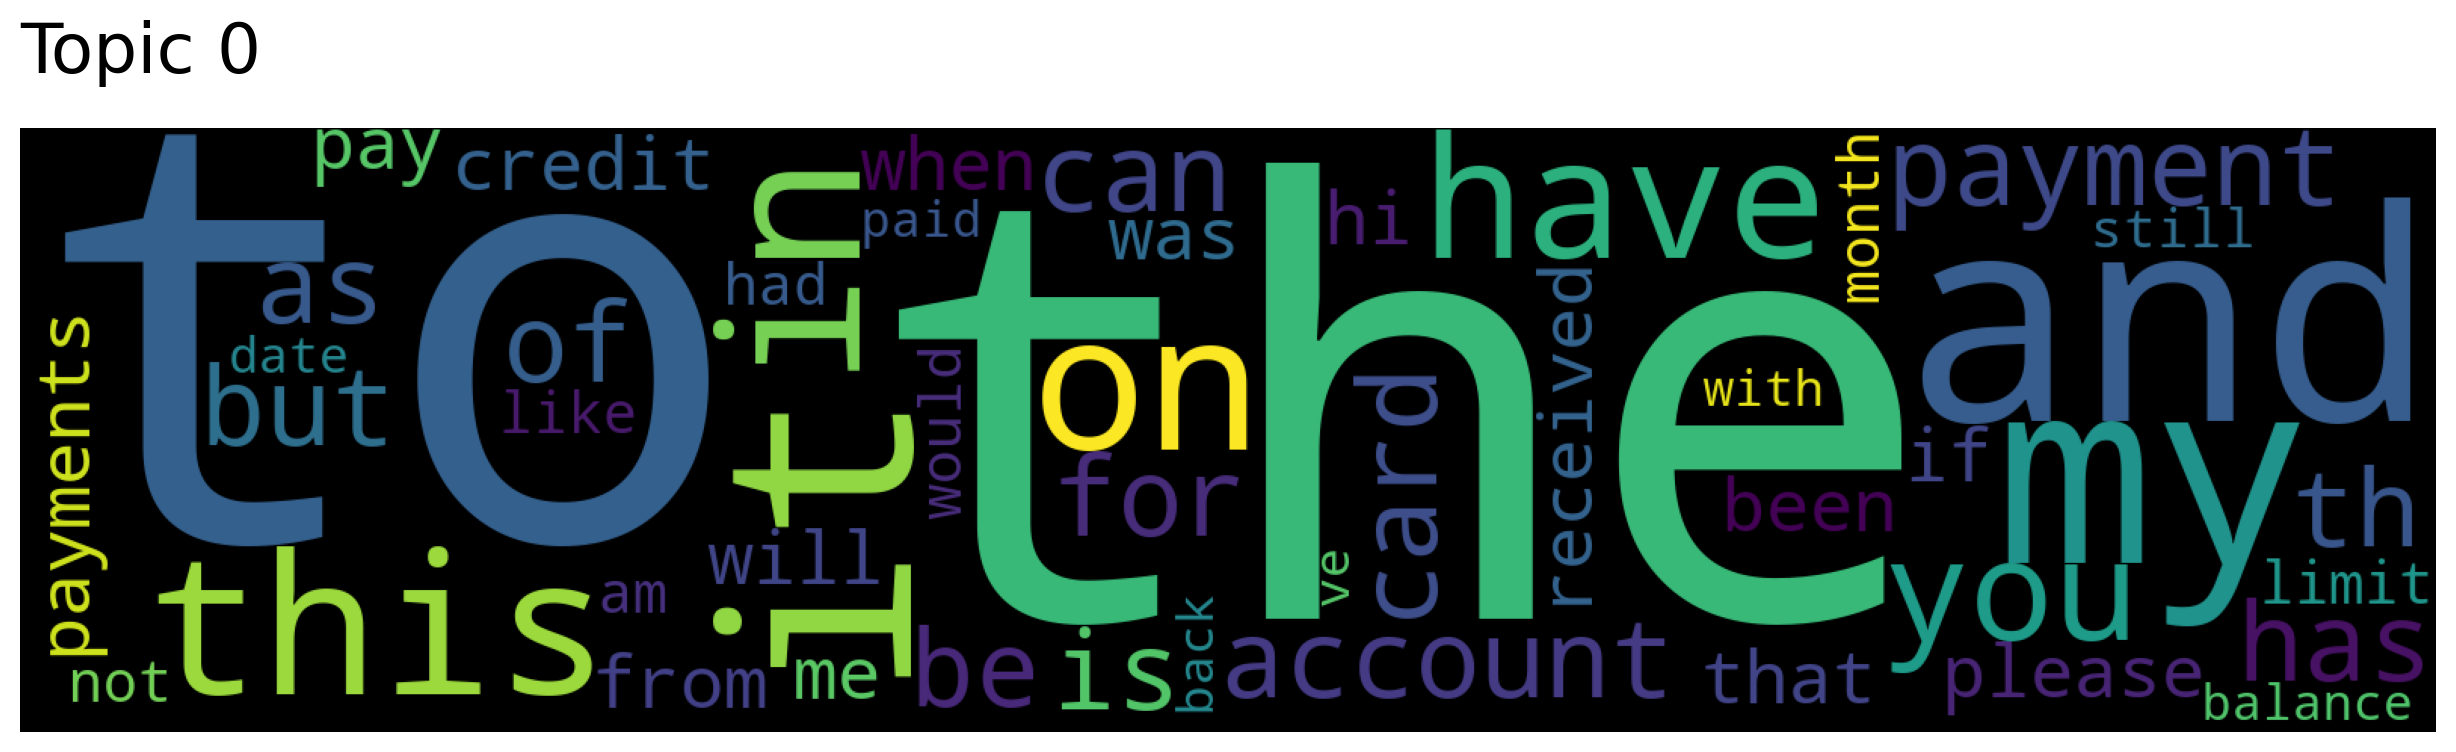

In [27]:
# vis
# time.sleep(120)
model.generate_topic_wordcloud(0)

In [28]:
# exportn_step:evaluate


def evaluate(model):
    topic_words, word_scores, topic_nums = model.get_topics(model.get_num_topics())

    topic_contains_non_empty_words = all([len(tw) > 0 for tw in topic_words])
    word_scores_in_range = word_scores.min() >= 0.0 and word_scores.max() <= 1.0
    as_many_items_as_topics = (
        model.get_num_topics() == len(topic_words) == word_scores.shape[0]
    )
    return (
        topic_contains_non_empty_words
        and word_scores_in_range
        and as_many_items_as_topics
    )

In [29]:
# slow
# debug
# Debug your Flow
# from metaflow import Metaflow
# os.environ['USER'] = 'e02079'
# flow = list(Metaflow())[0]
# run = flow.latest_run
# model2 = run['evaluate'].task.data.model

# Serve

In [30]:
# export
def serve_num_topics(model):
    return model.get_num_topics()

In [31]:
assert serve_num_topics(model) > 0

In [32]:
# export
def serve_reduced_hierarchies(model, desired_num_topics):
    return model.hierarchical_topic_reduction(desired_num_topics)

In [33]:
try:
    serve_reduced_hierarchies(model, -1)
except IndexError:
    print("Negative indexing not possible")
assert all(
    [
        type(tl) == list
        for tl in serve_reduced_hierarchies(
            model, np.random.choice(model.get_num_topics())
        )
    ]
)  # <= #topics
try:
    serve_reduced_hierarchies(model, model.get_num_topics() + 1)  # > #topics
except ValueError as ve:
    print(ve)

Negative indexing not possible


IndexError: index 1 is out of bounds for axis 0 with size 1

# [NBDEV] Export all NBs to modules

$$\sum_{i=1}^{k+1}i$$

This version is displayed inline: $\sum_{i=1}^{k+1}i$ . You can include text before and after.

In [ ]:
from nbdev.export import notebook2script

notebook2script()